In [1]:
import random as r
import cmath as m
import math

# machine epsillon
e = 1.0e-320

# Qubit class definition

In [2]:
class Qubit():
    MeasurementCount = 100 # need to fix this to avoid multi gate object instances
    def __init__(self, digBin):
        self.digBin = digBin
        if digBin == 0:
            self.a = 1
            self.b = 0
            self.register = {"alpha": self.a, "Beta": self.b, "digBin": digBin}
            
        elif digBin == 1:
            self.a = 0
            self.b = 1
            self.register = {"alpha": self.a, "Beta": self.b, "digBin": digBin}
            

    # def op(self, gateObj, gateName, ctrlQubitlist, lambda theta phi):
    def op(self, gateObj, gateName, ctrlQubitlist, *gateParam):        
        if gateName == "h":
            newState = gateObj.H(self.register)
        elif gateName == "x":
            newState = gateObj.x(self.register)    
        elif gateName == "cx":
            newState = gateObj.cx(self.register, ctrlQubitlist)   
        elif gateName == "p":
            newState = gateObj.p(self.register, ctrlQubitlist, gateParam[0])
        elif gateName == "u":
            newState = gateObj.u(self.register, gateParam[0], gateParam[1], gateParam[2], ctrlQubitlist)
        # updating the qubit register
        self.register.update(newState)
    
    
    def measure(self):
        return self.register
    
    def measureProb(self):
        return {"alpha": abs(self.register["alpha"]), "Beta": abs(self.register["Beta"]), "digBin":self.register["digBin"]}



class Gate():
    count0 = 0
    count1 = 0
    a = 0
    b = 0
    digbin = 0
    def H(self, state):
        if self.count0 >= 1000 and self.count1 >= 1000:
            raise Exception("Number of iterations should be 2000 to preserve probability. Reinitialize the qubit and simmulate again.")
        self.a = state["alpha"]
        self.b = state["Beta"]
        self.digbin =state["digBin"]
        LoopValidator = 1
        while LoopValidator:
            digbin = r.choice([0, 1])
            if self.count0 >= 1000 and digbin == 0:
                LoopValidator = 1
            elif self.count1 >= 1000 and digbin == 1:
                LoopValidator = 1
            else:
                LoopValidator = 0
        if self.count0 <= 1000 and digbin == 0:
            self.count0 += 1
            a = (self.a+self.b)
            b = (self.a-self.b)
            a = a*(1/m.sqrt(2))
            b = b*(1/m.sqrt(2))
            self.a = a
            self.b = b
            if abs(self.a) > 0.95:
                return ({"alpha": self.a, "Beta": self.b, "digBin": 0})
            if abs(self.b) > 0.95:
                return ({"alpha": self.a, "Beta": self.b, "digBin": 1})
            else:    
                return ({"alpha": self.a, "Beta": self.b, "digBin": digbin})
        elif self.count1 <= 1000 and digbin == 1:
            self.count1 += 1
            a = (self.a+self.b)
            b = (self.a-self.b)
            a = a*0.707
            b = b*0.707
            self.a = a
            self.b = b
            if abs(self.a) > 0.95:
                return ({"alpha": self.a, "Beta": self.b, "digBin": 0})
            if abs(self.b) > 0.95:
                return ({"alpha": self.a, "Beta": self.b, "digBin": 1})
            else:    
                return ({"alpha": self.a, "Beta": self.b, "digBin": digbin})
        else:
            raise Exception("Number of iterations should be 2000 to preserve probability. Reinitialize the qubit and simmulate again.")
            
            
    def x(self, state):
        self.a = state["alpha"]
        self.b = state["Beta"]
        self.digbin =state["digBin"]
        if self.digbin == 0:
            return ({"alpha": self.b, "Beta": self.a, "digBin": 1})
        elif self.digbin == 1:
            return ({"alpha": self.b, "Beta": self.a, "digBin": 0})

    def cx(self, state, ctrls):      # ctrls is the list of qubits (objects)
        self.a = state["alpha"]
        self.b = state["Beta"]
        self.digbin =state["digBin"]
        ctrl_on = 1
        for q in ctrls:
            if q.measure()["digBin"] == 0:
                ctrl_on = 0
                break
        if self.digbin == 0 and ctrl_on == 1:
            return ({"alpha": self.b, "Beta": self.a, "digBin": 1})
        elif self.digbin == 1 and ctrl_on == 1:
            return ({"alpha": self.b, "Beta": self.a, "digBin": 0})
        else:
            return ({"alpha": self.a, "Beta": self.b, "digBin": self.digbin})

    def p(self, state, ctrls, lamda):
        self.a = state["alpha"]
        self.b = state["Beta"]
        self.digbin =state["digBin"]

        ctrl_on = 1
        if ctrls != None:
            for q in ctrls:
                if q.measure()["digBin"] == 0:
                    ctrl_on = 0
                    break
        if ctrl_on == 1 and self.digbin == 1:
            self.a =  self.a 
            self.b = self.b*m.exp((m.pi/180)*lamda*1j) # dig binary udate TODO
            return ({"alpha": self.a, "Beta": self.b, "digBin": self.digbin})
        
        else:
            return ({"alpha": self.a, "Beta": self.b, "digBin": self.digbin})
            
    def u(self, state, l, t, p, ctrls):
        self.a = state["alpha"]
        self.b = state["Beta"]
        self.digbin =state["digBin"]
        
        ctrl_on = 1
        if ctrls != None:
            for q in ctrls:
                if q.measure()["digBin"] == 0:
                    ctrl_on = 0
                    break
        if ctrl_on == 1:
            a = (self.a*m.cos((m.pi/180)*t/2)) - (self.b*m.exp((m.pi/180)*l*1j)*m.sin((m.pi/180)*t/2))
            b = (self.a*m.exp((m.pi/180)*p*1j)*m.sin((m.pi/180)*t/2)) + (self.b*m.exp((m.pi/180)*(p+l)*1j)*m.cos(t/2))
            
            count1 = abs(a)**2*4000
            count0 = abs(b)**2*4000

            self.a = a
            self.b = b
            
            if self.count0 >= count0 and self.count1 >= count1:
                raise Exception("Number of iterations should be 2000 to preserve probability. Reinitialize the qubit and simmulate again.")

            LoopValidator = 1
            while LoopValidator:
                digbin = r.choice([0, 1])
                if self.count0 >= (count0) and digbin == 0:
                    LoopValidator = 1
                elif self.count1 >= (count1) and digbin == 1:
                    LoopValidator = 1
                else:
                    LoopValidator = 0

            if self.count0 <= count0 and digbin == 0:
                self.count0 += 1

                if abs(self.a) > 0.95:
                    return ({"alpha": self.a, "Beta": self.b, "digBin": 0})
                elif abs(self.b) > 0.95:
                    return ({"alpha": self.a, "Beta": self.b, "digBin": 1})
                else:    
                    return ({"alpha": self.a, "Beta": self.b, "digBin": digbin})
            elif self.count1 <= count1 and digbin == 1:
                self.count1 += 1

                if abs(self.a) > 0.95:
                    return ({"alpha": self.a, "Beta": self.b, "digBin": 0})
                elif abs(self.b) > 0.95:
                    return ({"alpha": self.a, "Beta": self.b, "digBin": 1})
                else:    
                    return ({"alpha": self.a, "Beta": self.b, "digBin": digbin})

        
        else:
            return ({"alpha": self.a, "Beta": self.b, "digBin": self.digbin})
        
        

def stateprob(measuredList, state):
    count = 0
    for s in measuredList:
        if s == state:
            count += 1
    return count/len(measuredList)*100

# Creating and Initializing the qubit

In [3]:
q0 = Qubit(0)
q1 = Qubit(0)
q2 = Qubit(0)
print(q0, q1, q2)

<__main__.Qubit object at 0x7f9cc9b16a00> <__main__.Qubit object at 0x7f9cc9b16490> <__main__.Qubit object at 0x7f9cc9b16850>


# Creating the gate object

##### need to create different gate object for each gate most of the time as gate object holds the randomized state information of each occurence of the gate. This is important for probability measurement.

In [4]:
g0 = object.__new__(Gate)
g1 = object.__new__(Gate)
g2 = object.__new__(Gate)
g3 = object.__new__(Gate)
g4 = object.__new__(Gate)
g5 = object.__new__(Gate)
g6 = object.__new__(Gate)
g7 = object.__new__(Gate)
g8 = object.__new__(Gate)
g9 = object.__new__(Gate)
g10 = object.__new__(Gate)
g11 = object.__new__(Gate)
g12 = object.__new__(Gate)

# Applying H gate on q0

In [5]:
# q0.op(g0, "h", None)

In [6]:
# print(q0.measure())

# Applying cx gate on q1 and ctrl at q0

In [7]:
# q1.op(g0, "cx", [q0])

In [8]:
# print(q1.measure())

In [9]:
# q0.__init__(0)
# q1.__init__(0)

# Bell Circuit implementation

In [10]:
statesList = []
for i in range(2000):
    q0.op(g0, "h", None)
    # print("At iteration ",i," q0 = ",q0.measure())
    
    q1.op(g1, "cx", [q0])
    q0.op(g8, "h", None)
    
    q0.op(g9, "h", None)
    q1.op(g10, "cx", [q0])
    q0.op(g2, "h", None)
    
    # q0.op(g3, "h", None)
    
    
    # q0.op(g1, "x", None)
    # q0.op(g2, "h", None)
    
    # q0.op(g2, "u", None, 180, 180, 0)       # Not Gate using u Gate
    
    # q1.op(g1, "h", None)
    # print("At iteration ",i," q1 = ",q1.measure())
    # print("\n\n")
    statesList.append(str(q1.measure()["digBin"]) + str(q0.measure()["digBin"]))
    q0.__init__(0)
    q1.__init__(0)

# 3 qubit

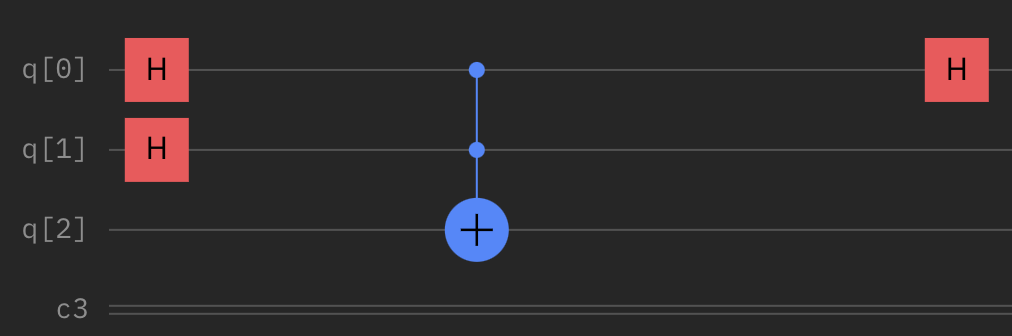

In [11]:
# statesList = []
# for i in range(2000):
#     q0.op(g0, "h", None)
#     print("At iteration ",i," q0 = ",q0.measure())
    
#     q1.op(g1, "h", None)
#     print("At iteration ",i," q1 = ",q1.measure())
    
#     q2.op(g1, "cx", [q0, q1])
#     print("At iteration ",i," q2 = ",q2.measure())
    
#     q0.op(g0, "x", None)
#     # print("At iteration ",i," q0 = ",q0.measure())
    
#     # q0.op(g2, "h", None)       #failing the design
#     print("At iteration ",i," q0 = ",q0.measure())
    
#     # q2.op(g1, "cx", [q0, q1])
    
#     print("\n\n")
#     statesList.append(str(q2.measure()["digBin"]) + str(q1.measure()["digBin"]) + str(q0.measure()["digBin"]))
#     q0.__init__(0)
#     q1.__init__(0)
#     q2.__init__(0)
    

# QFT :

In [12]:
# statesList = []
# for i in range(2000):
#     # q0.__init__(0)
#     q0.op(g0, "r", 180, None)
#     print("At iteration ",i," q1 = ",q0.measure())
#     q0.op(g0, "h", None, None)
#     print("At iteration ",i," q1 = ",q0.measure())
#     print("\n\n")
#     statesList.append(str(q1.measure()["digBin"])+ str(q0.measure()["digBin"]))
#     q0.__init__(1)
#     q1.__init__(1)

# Grover's 

In [13]:
# statesList = []
# for i in range(2000):

#     q0.op(g0, "h", None, None)
#     q1.op(g1, "h", None, None)
    
#     # q0.op(g5, "x", None, None)
#     q1.op(g2, "h", None, None)
#     q1.op(g2, "cx", [q0])
#     q1.op(g3, "h", None, None)
#     # q0.op(g5, "x", None, None)

#     q0.op(g4, "h", None, None)
#     q0.op(g12, "h", None, None) # enforcing the 0
#     q1.op(g5, "h", None, None)
# #     # print("At iteration ",i," q1 = ",q1.measure())
# #     # print("At iteration ",i," q0 = ",q0.measure())
#     q0.op(g5, "x", None, None)
#     q1.op(g5, "x", None, None)
# #     # print("At iteration ",i," q1 = ",q1.measure())
# #     # print("At iteration ",i," q0 = ",q0.measure())
    
#     q1.op(g6, "h", None, None)
# #     q1.op(g6, "cx",[q0])
# #     # q1.op(g11, "h", None, None)  #enforcing 0 state again
# #     q1.op(g7, "h", None, None)
# #     # print("At iteration ",i," q1 = ",q1.measure())
# #     # print("At iteration ",i," q0 = ",q0.measure())
    
# #     q0.op(g7, "x", None, None)
# #     q1.op(g7, "x", None, None)
# #     # print("At iteration ",i," q1 = ",q1.measure())
# #     # print("At iteration ",i," q0 = ",q0.measure())
    
# #     # q0.op(g10, "h", None, None)  #enforcing 0 state again
# #     q0.op(g8, "h", None, None)
# #     # print("At iteration ",i," q0 = ",q0.measure())

# #     q1.op(g9, "h", None, None)
# #     # print("At iteration ",i," q1 = ",q1.measure())

# #     # print("\n\n")
#     statesList.append(str(q1.measure()["digBin"])+ str(q0.measure()["digBin"]))
#     q0.__init__(0)
#     q1.__init__(0)

# QFT and Inverse QFT

In [14]:
# # inverse QFT
# statesList = []
# for i in range(2000):
#     # q0.op(g0, "u", None, 180, 90, 0)       # Hadmard Gate using u Gate
#     # q0.op(g0, "u", None, 180, 90, 0)       
#     # q1.op(g1, "u", None, 180, 90, 0)       
#     # q2.op(g2, "u", None, 180, 90, 0)      
#     q0.op(g0, "h", None,)      
#     q1.op(g1, "h", None,)      
#     q2.op(g2, "h", None,)      

#     q0.op(g3, "u", None, 3*180/4, 0, 0)     
#     q1.op(g4, "u", None, 3*180/2, 0, 0)       
#     q2.op(g5, "u", None, 3*180, 0, 0)      

#     q2.op(g5, "cx", [q0])      
#     q0.op(g5, "cx", [q2])      
#     q2.op(g5, "cx", [q0])      

#     # q0.op(g9, "h", None,)      
#     # q1.op(g10, "h", None,)      
#     # q2.op(g11, "h", None,)    
    
#     q0.op(g6, "h", None,)      
#     q1.op(g6, "p", [q0], -90)

#     q1.op(g7, "h", None,)      
#     q2.op(g7, "p", [q1], -90)
    
#     q2.op(g8, "p", [q0], -45)
#     q2.op(g8, "h", None,)      
    
    
#     print("At iteration ",i," q1 = ",q1.measureProb())
#     print("At iteration ",i," q0 = ",q0.measureProb())
    
#     print("\n\n")
#     statesList.append(str(q2.measure()["digBin"])+ str(q1.measure()["digBin"])+ str(q0.measure()["digBin"]))
#     q0.__init__(0)
#     q1.__init__(0)
#     q2.__init__(0)

In [15]:
# statesList = []
# for i in range(200):
# # QFT for |101>   
#     q0.op(g0, "x", None)      
#     q2.op(g0, "x", None)       
    
#     q2.op(g0, "h", None)
    
#     q0.op(g1, "p", [q2], 45)
    
#     q1.op(g2, "p", [q2], 90)
    
    
# #     print("At iteration ",i," q2 = ",q2.measure(), " Theta: ", math.atan(abs(q2.measure()["Beta"])/(abs(q2.measure()["alpha"])+e))*(180/m.pi)*2
# #          ,"Phase: ", (math.atan(q2.measure()["Beta"].imag/(q2.measure()["Beta"].real+e)) - math.atan(q2.measure()["alpha"].imag/(q2.measure()["alpha"].real+e)))*180/m.pi)
# #     print("At iteration ",i," q1 = ",q1.measure(), " Theta: ", math.atan(abs(q1.measure()["Beta"])/(abs(q1.measure()["alpha"])+e))*(180/m.pi)*2
# #          ,"Phase: ", (math.atan(q1.measure()["Beta"].imag/(q1.measure()["Beta"].real+e)) - math.atan(q1.measure()["alpha"].imag/(q1.measure()["alpha"].real+e)))*180/m.pi)
# #     print("At iteration ",i," q0 = ",q0.measure(), " Theta: ", math.atan(abs(q0.measure()["Beta"])/(abs(q0.measure()["alpha"])+e))*(180/m.pi)*2
# #          ,"Phase: ", (math.atan(q0.measure()["Beta"].imag/(q0.measure()["Beta"].real+e)) - math.atan(q0.measure()["alpha"].imag/(q0.measure()["alpha"].real+e)))*180/m.pi)
    
# #     print("\n") 

#     q1.op(g3, "h", None)      
    
#     print("At iteration ",i," q2 = ",q2.measure(), " Theta: ", math.atan(abs(q2.measure()["Beta"])/(abs(q2.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q2.measure()["Beta"].imag/(q2.measure()["Beta"].real+e)) - math.atan(q2.measure()["alpha"].imag/(q2.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q1 = ",q1.measure(), " Theta: ", math.atan(abs(q1.measure()["Beta"])/(abs(q1.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q1.measure()["Beta"].imag/(q1.measure()["Beta"].real+e)) - math.atan(q1.measure()["alpha"].imag/(q1.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q0 = ",q0.measure(), " Theta: ", math.atan(abs(q0.measure()["Beta"])/(abs(q0.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q0.measure()["Beta"].imag/(q0.measure()["Beta"].real+e)) - math.atan(q0.measure()["alpha"].imag/(q0.measure()["alpha"].real+e)))*180/m.pi)
#     print("==========================================================================================================\n\n")

#     q0.op(g4, "p", [q1], 90)
    
#     q0.op(g5, "h", None)      

    
# #     # q2.op(g5, "cx", [q0])      
# #     # q0.op(g5, "cx", [q2])      
# #     # q2.op(g5, "cx", [q0])   
    
# # # Inverse QFT for |101>   
#     q0.op(g6, "h", None)      
    
#     q1.op(g7, "p", [q0], 90)

#     print("At iteration ",i," q2 = ",q2.measure(), " Theta: ", math.atan(abs(q2.measure()["Beta"])/(abs(q2.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q2.measure()["Beta"].imag/(q2.measure()["Beta"].real+e)) - math.atan(q2.measure()["alpha"].imag/(q2.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q1 = ",q1.measure(), " Theta: ", math.atan(abs(q1.measure()["Beta"])/(abs(q1.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q1.measure()["Beta"].imag/(q1.measure()["Beta"].real+e)) - math.atan(q1.measure()["alpha"].imag/(q1.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q0 = ",q0.measure(), " Theta: ", math.atan(abs(q0.measure()["Beta"])/(abs(q0.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q0.measure()["Beta"].imag/(q0.measure()["Beta"].real+e)) - math.atan(q0.measure()["alpha"].imag/(q0.measure()["alpha"].real+e)))*180/m.pi)
#     print("==========================================================================================================\n\n")
    
#     q1.op(g8, "h", None,)   
    
#     print("At iteration ",i," q2 = ",q2.measure(), " Theta: ", math.atan(abs(q2.measure()["Beta"])/(abs(q2.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q2.measure()["Beta"].imag/(q2.measure()["Beta"].real+e)) - math.atan(q2.measure()["alpha"].imag/(q2.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q1 = ",q1.measure(), " Theta: ", math.atan(abs(q1.measure()["Beta"])/(abs(q1.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q1.measure()["Beta"].imag/(q1.measure()["Beta"].real+e)) - math.atan(q1.measure()["alpha"].imag/(q1.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q0 = ",q0.measure(), " Theta: ", math.atan(abs(q0.measure()["Beta"])/(abs(q0.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q0.measure()["Beta"].imag/(q0.measure()["Beta"].real+e)) - math.atan(q0.measure()["alpha"].imag/(q0.measure()["alpha"].real+e)))*180/m.pi)
#     print("==========================================================================================================\n\n")
    
#     q2.op(g9, "p", [q1], 90)
    
    
#     q0.op(g10, "p", [q2], 45)
#     q2.op(g11, "h", None)     
    

#     print("===Final Result===\n")
#     print("At iteration ",i," q2 = ",q2.measure(), " Theta: ", math.atan(abs(q2.measure()["Beta"])/(abs(q2.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q2.measure()["Beta"].imag/(q2.measure()["Beta"].real+e)) - math.atan(q2.measure()["alpha"].imag/(q2.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q1 = ",q1.measure(), " Theta: ", math.atan(abs(q1.measure()["Beta"])/(abs(q1.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q1.measure()["Beta"].imag/(q1.measure()["Beta"].real+e)) - math.atan(q1.measure()["alpha"].imag/(q1.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q0 = ",q0.measure(), " Theta: ", math.atan(abs(q0.measure()["Beta"])/(abs(q0.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q0.measure()["Beta"].imag/(q0.measure()["Beta"].real+e)) - math.atan(q0.measure()["alpha"].imag/(q0.measure()["alpha"].real+e)))*180/m.pi)
#     print("==========================================================================================================\n\n")
    
#     statesList.append(str(q2.measure()["digBin"]) + str(q1.measure()["digBin"])+ str(q0.measure()["digBin"]))
#     q0.__init__(0)
#     q1.__init__(0)
#     q2.__init__(0)
    
# # add phase vlues to get state phase

# # observation:
# #     maybe (-0) mean negative phase(pi/2)
# #     total phase after gate will be change in phase occured in anti clkwise direction.  

In [16]:
# # inverse QFT
# statesList = []
# for i in range(2000):
#     # q0.op(g0, "u", None, 180, 90, 0)       # Hadmard Gate using u Gate
#     q0.op(g0, "u", None, 0, 90, 0)       
#     q1.op(g1, "u", None, 0, 90, 0)       
#     q2.op(g2, "u", None, 0, 90, 0)      

#     q0.op(g3, "u", None, 3*180/4, 0, 0)     
#     q1.op(g4, "u", None, 3*180/2, 0, 0)       
#     q2.op(g5, "u", None, 3*180, 0, 0)      

#     # q2.op(g5, "cx", [q0])      
#     # q0.op(g5, "cx", [q2])      
#     # q2.op(g5, "cx", [q0])      

#     q0.op(g6, "h", None,)      
# #     q1.op(g6, "p", [q0], -90)

# #     q1.op(g7, "h", None,)      
# #     q2.op(g7, "p", [q1], -90)
    
# #     q2.op(g8, "p", [q0], -45)
# #     q2.op(g8, "h", None,)      
    
#     print("===Final Result===\n")
#     print("At iteration ",i," q2 = ",q2.measure(), " Theta: ", math.atan(abs(q2.measure()["Beta"])/(abs(q2.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q2.measure()["Beta"].imag/(q2.measure()["Beta"].real+e)) - math.atan(q2.measure()["alpha"].imag/(q2.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q1 = ",q1.measure(), " Theta: ", math.atan(abs(q1.measure()["Beta"])/(abs(q1.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q1.measure()["Beta"].imag/(q1.measure()["Beta"].real+e)) - math.atan(q1.measure()["alpha"].imag/(q1.measure()["alpha"].real+e)))*180/m.pi)
#     print("At iteration ",i," q0 = ",q0.measure(), " Theta: ", math.atan(abs(q0.measure()["Beta"])/(abs(q0.measure()["alpha"])+e))*(180/m.pi)*2
#          ,"Phase: ", (math.atan(q0.measure()["Beta"].imag/(q0.measure()["Beta"].real+e)) - math.atan(q0.measure()["alpha"].imag/(q0.measure()["alpha"].real+e)))*180/m.pi)
#     print("==========================================================================================================\n\n")
 
    
#     print("\n\n")
#     statesList.append(str(q2.measure()["digBin"])+ str(q1.measure()["digBin"])+ str(q0.measure()["digBin"]))
#     q0.__init__(0)
#     q1.__init__(0)
#     q2.__init__(0)

# Simulation Result

In [17]:
import itertools
n = 2
sqs = [''.join(s) for s in list(itertools.product(*[['0', '1']] * n))]
for x in range(2**n):
    print(sqs[x], " => ", '%.2f' % stateprob(statesList, sqs[x]))

00  =>  49.20
01  =>  0.00
10  =>  50.80
11  =>  0.00


In [18]:
# # inverse QFT
# statesList = []
# for i in range(2000):
#     # q0.op(g0, "u", None, 180, 90, 0)       # Hadmard Gate using u Gate
#     q0.op(g0, "u", None, 180, 90, 0)       
#     q1.op(g1, "u", None, 180, 90, 0)       
#     q2.op(g2, "u", None, 180, 90, 0)      

#     q0.op(g3, "u", None, 3*180/4, 0, 0)     
#     q1.op(g4, "u", None, 3*180/2, 0, 0)       
#     q2.op(g5, "u", None, 3*180, 0, 0)      

#     q2.op(g5, "cx", [q0])      
#     q0.op(g5, "cx", [q2])      
#     q2.op(g5, "cx", [q0])      

#     q0.op(g6, "h", None,)      
#     q1.op(g6, "p", [q0], -90)

#     q1.op(g7, "h", None,)      
#     q2.op(g7, "p", [q1], -90)
    
#     q2.op(g8, "p", [q0], -45)
#     q2.op(g8, "h", None,)      
    
    
#     print("At iteration ",i," q1 = ",q1.measureProb())
#     print("At iteration ",i," q0 = ",q0.measureProb())
    
#     print("\n\n")
#     statesList.append(str(q2.measure()["digBin"])+ str(q1.measure()["digBin"])+ str(q0.measure()["digBin"]))
#     q0.__init__(0)
#     q1.__init__(0)
#     q2.__init__(0)